<a href="https://colab.research.google.com/github/fzanart/Socialz/blob/main/es_plus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scipy --upgrade

In [2]:
import numpy as np
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive/')
import random
from scipy.stats import qmc
from tqdm import tqdm
import time

Mounted at /content/drive/


In [3]:
# Read the data
df = pd.read_csv('/content/drive/MyDrive/Socialz/cobol_pullrequests.csv', usecols=['login', 'name'])
df

,login,name
0,vim-sroberge,vimaec/g3d
1,vim-sroberge,vimaec/g3d
2,vim-sroberge,vimaec/g3d
3,vim-sroberge,vimaec/g3d
4,mavimaec,vimaec/g3d
...,...,...
1328,joe-tingsanchali-sonarsource,SonarSource/sonar-scanning-examples
1329,joe-tingsanchali-sonarsource,SonarSource/sonar-scanning-examples
1330,joe-tingsanchali-sonarsource,SonarSource/sonar-scanning-examples
1331,joe-tingsanchali-sonarsource,SonarSource/sonar-scanning-examples


In [4]:
# Add user (u: ) repo (r: ) indicator for each node
df['login'] = df['login'].apply(lambda x: 'u: '+x)
df['name'] = df['name'].apply(lambda x: 'r: '+x)

In [5]:
# Build the adjacency matrix for user - repo (and repo - user) interactions.
adj_matrix = pd.crosstab(df['login'], df['name']).astype(float)
idx = adj_matrix.columns.union(adj_matrix.index)
adj_matrix = adj_matrix.reindex(index = idx, columns=idx, fill_value=0.0)

In [6]:
# Add user - user interactions.
matrix_elements = np.sort(df['login'].unique(), axis=0)
repo_len = len(df['name'].unique())

def cosine_similarity(vector_a, vector_b):
    
    norma = (np.linalg.norm(vector_a)*np.linalg.norm(vector_b))

    if norma > 0:

        cos_sim = np.dot(vector_a,vector_b)/ norma

    else:

        cos_sim = 0

    return cos_sim

#Initialise an auxiliar matrix to record the user - user similarities
shape = (len(matrix_elements), len(matrix_elements))
aux_matrix = pd.DataFrame((np.zeros(shape=shape)), columns=matrix_elements, index=matrix_elements)

for i in matrix_elements:
    for j in matrix_elements:

        # Compare row vectors
        aux_vector_a = adj_matrix.loc[i].to_numpy()[:repo_len]
        aux_vector_b = adj_matrix.loc[j].to_numpy()[:repo_len]
        
        score = cosine_similarity(aux_vector_a, aux_vector_b)
        aux_matrix.at[i, j] = score

In [7]:
# Set the diagonal to 0 (Same user-user interaction = 0)
np.fill_diagonal(aux_matrix.to_numpy(), 0)

In [8]:
# Fill adj_matrix with aux_matrix data
for column in aux_matrix.columns:
    for row in aux_matrix.index:

        aux = aux_matrix.at[row, column]
        adj_matrix.at[row, column] = aux

In [36]:
# Compute graph metrics

def graph_metrics(adj_matrix):
  # Build the initial graph from adj_matrix.
  G = nx.from_pandas_adjacency(adj_matrix, create_using=nx.DiGraph)
  d = {'degree' : {node:val for (node, val) in G.degree()} ,      # measure of activity of the node.
       'betweenness_centrality' : nx.betweenness_centrality(G)}   # measure of relative importance of the node.

  metric_df = pd.DataFrame(d)

  # normalise node degree values  https://www.statology.org/normalize-data-between-0-and-1/
  # zi = (xi – min(x)) / (max(x) – min(x))
  metric_df['degree'] = metric_df['degree'].apply(lambda x: (x - metric_df['degree'].min())/(metric_df['degree'].max() - metric_df['degree'].min()))
  
  #TODO:  filter users
  
  return metric_df

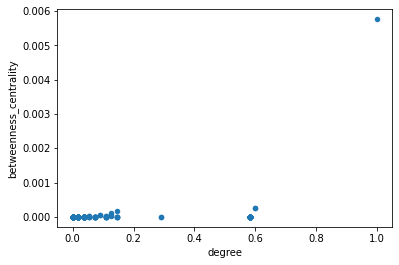

In [38]:
# TODO: plot graph metric distribution
metric_df = graph_metrics(adj_matrix)
metric_df.plot.scatter(x='degree', y='betweenness_centrality')

In [39]:
# Evaluate metrics in terms of star-discrepancy
def objective(candidate):
  return qmc.discrepancy(candidate, method='L2-star',workers=-1)

In [40]:
# TODO: 
objective(metric_df)

0.6763834378398914

In [ ]:
# Mutator, give it an adj_matrix, and it will return the mutated adj_matrix.

def mutate(adj_matrix, node): # Do I nedd to pass the node? or should I ramdomly choose one?

  # Create a graph from the adj. matrix, and list the connected componnets.
  G = nx.from_pandas_adjacency(adj_matrix, create_using=nx.DiGraph)
  connected_components = list(nx.weakly_connected_components(G))

  # Define a method to return the connected component of a particular node.
  def get_component(node, connected_components):
    for component in connected_components:
      if node in component:
        return component
    else:
      return set()

  # get adj_matrix of the node's connected component (sub graph) 
  sub_am = nx.to_pandas_adjacency(G, list(get_component(node, connected_components)))

  # Mutate, keep iterating (shuffling) until .loc[node,node] = 0.0
  aux = False
  while aux is False:
    np.random.shuffle(sub_am.loc[node])
    if sub_am.loc[node,node] == 0.0:
      aux = True

  # Fill adj_matrix with sub graph adj. matrix (sub_am) data
  for column in sub_am.columns:
      for row in sub_am.index:

          aux = sub_am.at[row, column]
          adj_matrix.at[row, column] = aux

  adj_matrix.loc[sub_am.index,sub_am.columns]

  return adj_matrix

In [ ]:
# es_plus